# 🔍 Pattern Analysis & Feature Extraction
#
## Uncovering Geometric and Textural Fire Patterns
#
This notebook explores advanced pattern analysis techniques to extract rich geometric
and textural features from our 4-channel fire fingerprints. These features enable
deeper understanding of fire behavior and support similarity search applications.
#
**Features**: 20+ geometric, complexity, texture, and curvature-based descriptors


## 📋 What You'll Learn
#
1. **Geometric Features**: Shape-based fire characteristics
2. **Complexity Analysis**: Fractal dimensions and boundary roughness
3. **Texture Features**: GLCM analysis of distance transforms
4. **Curvature Analysis**: Boundary complexity and burning patterns
5. **Feature Visualization**: Understanding feature distributions and correlations


## 🛠️ Setup and Imports


In [2]:
import numpy as np
import cv2
from scipy import ndimage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from skimage import measure, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load processed data function
def load_processed_data(data_dir="demo_processed_data"):
    """Load previously processed data"""
    data_path = Path(data_dir)

    print(f"Loading processed data from {data_path}...")

    # Load fingerprints
    fingerprints = np.load(data_path / 'fingerprints.npy')

    # Load labels and metadata
    with open(data_path / 'labels.pkl', 'rb') as f:
        labels = pickle.load(f)

    with open(data_path / 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    # Load encoders
    with open(data_path / 'encoders.json', 'r') as f:
        encoders = json.load(f)

    print(f"✓ Loaded {len(fingerprints):,} fingerprints")
    print(f"✓ Fingerprint shape: {fingerprints.shape}")

    return fingerprints, labels, metadata, encoders

print("🔥 Fire Fingerprinting System - Pattern Analysis & Features")
print("=" * 60)
print("📊 Extracting geometric and textural features from fire fingerprints")
print("💡 This notebook demonstrates advanced pattern analysis")

🔥 Fire Fingerprinting System - Pattern Analysis & Features
📊 Extracting geometric and textural features from fire fingerprints
💡 This notebook demonstrates advanced pattern analysis


## 🏗️ Fire Pattern Analyzer Class
#
A comprehensive feature extraction system for fire fingerprints that computes
20+ different geometric and textural features.


In [3]:
class FirePatternAnalyzer:
    """Analyze fire patterns and extract features from fingerprints"""

    def __init__(self):
        self.feature_names = []
        self.feature_descriptions = {}
        self._initialize_feature_definitions()

    def _initialize_feature_definitions(self):
        """Initialize feature names and descriptions"""
        self.feature_descriptions = {
            # Shape-based features
            'area': 'Total area of fire boundary',
            'perimeter': 'Total perimeter length',
            'compactness': 'Compactness ratio (4π*area/perimeter²)',
            'elongation': 'Elongation ratio (major/minor axis)',
            'solidity': 'Ratio of area to convex hull area',
            'extent': 'Ratio of area to bounding box area',
            'eccentricity': 'Eccentricity of fitted ellipse',
            'orientation': 'Orientation of major axis',

            # Complexity features
            'fractal_dimension': 'Fractal dimension of boundary',
            'boundary_roughness': 'Roughness of fire boundary',
            'convexity_defects': 'Number of convexity defects',
            'shape_complexity': 'Overall shape complexity measure',

            # Texture features (from distance transform)
            'texture_contrast': 'Contrast in distance transform',
            'texture_homogeneity': 'Homogeneity in distance transform',
            'texture_energy': 'Energy in distance transform',
            'texture_correlation': 'Correlation in distance transform',

            # Curvature features
            'mean_curvature': 'Mean boundary curvature',
            'curvature_variance': 'Variance in boundary curvature',
            'max_curvature': 'Maximum boundary curvature',
            'curvature_peaks': 'Number of curvature peaks',

            # Multi-scale features
            'multi_scale_area': 'Area at different scales',
            'multi_scale_perimeter': 'Perimeter at different scales',
            'multi_scale_complexity': 'Complexity at different scales'
        }

        self.feature_names = list(self.feature_descriptions.keys())

    # Shape-based features
    def extract_shape_features(self, fingerprint):
        """Extract basic shape features from fire fingerprint"""
        shape_mask = fingerprint[:, :, 0]  # Binary shape channel

        features = {}

        # Basic shape properties
        contours, _ = cv2.findContours(
            (shape_mask * 255).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) > 0:
            # Get largest contour
            main_contour = max(contours, key=cv2.contourArea)

            # Area and perimeter
            features['area'] = cv2.contourArea(main_contour)
            features['perimeter'] = cv2.arcLength(main_contour, True)

            # Compactness (circularity)
            if features['perimeter'] > 0:
                features['compactness'] = 4 * np.pi * features['area'] / (features['perimeter'] ** 2)
            else:
                features['compactness'] = 0

            # Fit ellipse for elongation and orientation
            if len(main_contour) >= 5:  # Need at least 5 points for ellipse fitting
                ellipse = cv2.fitEllipse(main_contour)
                (center, axes, angle) = ellipse
                major_axis, minor_axis = axes

                features['elongation'] = major_axis / minor_axis if minor_axis > 0 else 0
                features['orientation'] = angle

                # Eccentricity
                features['eccentricity'] = np.sqrt(1 - (minor_axis/major_axis)**2) if major_axis > 0 else 0
            else:
                features['elongation'] = 0
                features['orientation'] = 0
                features['eccentricity'] = 0

            # Convex hull properties
            hull = cv2.convexHull(main_contour)
            hull_area = cv2.contourArea(hull)
            features['solidity'] = features['area'] / hull_area if hull_area > 0 else 0

            # Bounding box
            x, y, w, h = cv2.boundingRect(main_contour)
            bounding_area = w * h
            features['extent'] = features['area'] / bounding_area if bounding_area > 0 else 0

        return features

    # Complexity features
    def extract_complexity_features(self, fingerprint):
        """Extract complexity features from fire fingerprint"""
        shape_mask = fingerprint[:, :, 0]
        distance_transform = fingerprint[:, :, 1]

        features = {}

        # Fractal dimension using box counting
        features['fractal_dimension'] = self._calculate_fractal_dimension(shape_mask)

        # Boundary roughness (standard deviation of boundary distances)
        contours, _ = cv2.findContours(
            (shape_mask * 255).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE
        )

        if len(contours) > 0:
            main_contour = max(contours, key=cv2.contourArea)

            # Calculate distances from boundary to centroid
            M = cv2.moments(main_contour)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                distances = []
                for point in main_contour:
                    x, y = point[0]
                    dist = np.sqrt((x - cx)**2 + (y - cy)**2)
                    distances.append(dist)

                features['boundary_roughness'] = np.std(distances) if distances else 0
            else:
                features['boundary_roughness'] = 0

            # Convexity defects
            hull = cv2.convexHull(main_contour, returnPoints=False)
            if len(hull) > 2:
                defects = cv2.convexityDefects(main_contour, hull)
                features['convexity_defects'] = len(defects) if defects is not None else 0
            else:
                features['convexity_defects'] = 0

        # Overall shape complexity (combination of features)
        features['shape_complexity'] = (
            features['fractal_dimension'] +
            features['boundary_roughness'] * 0.01 +
            features['convexity_defects'] * 0.1
        )

        return features

    def _calculate_fractal_dimension(self, shape_mask, max_box_size=32):
        """Calculate fractal dimension using box counting method"""
        if shape_mask.sum() == 0:
            return 0.0

        # Find boundary pixels
        contours, _ = cv2.findContours(
            (shape_mask * 255).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE
        )

        if len(contours) == 0:
            return 0.0

        main_contour = max(contours, key=cv2.contourArea)
        boundary_pixels = main_contour.reshape(-1, 2)

        if len(boundary_pixels) < 10:
            return 1.0  # Minimum complexity

        # Box counting
        box_sizes = []
        counts = []

        for box_size in range(2, min(max_box_size, len(boundary_pixels)//4)):
            # Create grid
            min_coords = boundary_pixels.min(axis=0)
            max_coords = boundary_pixels.max(axis=0)
            grid_size = np.ceil((max_coords - min_coords) / box_size).astype(int)

            # Count occupied boxes
            occupied = set()
            for pixel in boundary_pixels:
                grid_pos = ((pixel - min_coords) / box_size).astype(int)
                occupied.add(tuple(grid_pos))

            if len(occupied) > 0:
                box_sizes.append(box_size)
                counts.append(len(occupied))

        # Calculate fractal dimension
        if len(box_sizes) >= 3:
            # Linear regression on log-log plot
            log_sizes = np.log(1.0 / np.array(box_sizes))
            log_counts = np.log(np.array(counts))

            # Simple linear regression
            slope, intercept = np.polyfit(log_sizes, log_counts, 1)
            fractal_dim = slope
        else:
            fractal_dim = 1.0

        return max(1.0, min(2.0, fractal_dim))  # Clamp to reasonable range

    # Texture features
    def extract_texture_features(self, fingerprint):
        """Extract texture features using GLCM from distance transform"""
        distance_transform = fingerprint[:, :, 1]

        # Normalize to 0-255 range for GLCM
        if distance_transform.max() > distance_transform.min():
            texture_img = ((distance_transform - distance_transform.min()) /
                          (distance_transform.max() - distance_transform.min()) * 255).astype(np.uint8)
        else:
            texture_img = (distance_transform * 255).astype(np.uint8)

        features = {}

        try:
            # Calculate GLCM (Gray Level Co-occurrence Matrix)
            glcm = graycomatrix(texture_img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                               symmetric=True, normed=True)

            # Extract texture features
            features['texture_contrast'] = graycoprops(glcm, 'contrast').mean()
            features['texture_homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
            features['texture_energy'] = graycoprops(glcm, 'energy').mean()
            features['texture_correlation'] = graycoprops(glcm, 'correlation').mean()

        except Exception as e:
            # Fallback values if GLCM calculation fails
            features['texture_contrast'] = 0
            features['texture_homogeneity'] = 0
            features['texture_energy'] = 0
            features['texture_correlation'] = 0

        return features

    # Curvature features
    def extract_curvature_features(self, fingerprint):
        """Extract curvature-based features from boundary curvature channel"""
        curvature_map = fingerprint[:, :, 2]

        features = {}

        # Basic curvature statistics
        features['mean_curvature'] = np.mean(curvature_map)
        features['curvature_variance'] = np.var(curvature_map)
        features['max_curvature'] = np.max(curvature_map)

        # Count curvature peaks (local maxima)
        # Apply Gaussian blur to reduce noise
        smoothed = cv2.GaussianBlur(curvature_map.astype(np.float32), (5, 5), 1.0)

        # Find local maxima
        kernel = np.array([[-1,-1,-1],
                          [-1, 8,-1],
                          [-1,-1,-1]])
        peaks = cv2.filter2D(smoothed, -1, kernel)
        threshold = np.mean(smoothed) + np.std(smoothed)
        features['curvature_peaks'] = np.sum(peaks > threshold)

        return features

    # Multi-scale features
    def extract_multiscale_features(self, fingerprint, scales=[0.25, 0.5, 1.0, 2.0]):
        """Extract features at multiple scales"""
        features = {}

        areas = []
        perimeters = []
        complexities = []

        for scale in scales:
            # Resize fingerprint
            h, w = fingerprint.shape[:2]
            new_size = (int(w * scale), int(h * scale))

            if new_size[0] > 0 and new_size[1] > 0:
                scaled = cv2.resize(fingerprint, new_size, interpolation=cv2.INTER_LINEAR)

                # Extract shape features at this scale
                scale_features = self.extract_shape_features(scaled)
                scale_complexity = self.extract_complexity_features(scaled)

                areas.append(scale_features.get('area', 0))
                perimeters.append(scale_features.get('perimeter', 0))
                complexities.append(scale_complexity.get('shape_complexity', 0))

        # Store multi-scale statistics
        features['multi_scale_area'] = np.mean(areas) if areas else 0
        features['multi_scale_perimeter'] = np.mean(perimeters) if perimeters else 0
        features['multi_scale_complexity'] = np.mean(complexities) if complexities else 0

        return features

    # Main feature extraction method
    def extract_all_features(self, fingerprint):
        """Extract all features from a single fingerprint"""
        if fingerprint is None or fingerprint.shape[-1] != 4:
            return {name: 0 for name in self.feature_names}

        features = {}

        try:
            # Extract each feature group
            features.update(self.extract_shape_features(fingerprint))
            features.update(self.extract_complexity_features(fingerprint))
            features.update(self.extract_texture_features(fingerprint))
            features.update(self.extract_curvature_features(fingerprint))
            features.update(self.extract_multiscale_features(fingerprint))

            # Ensure all features are present
            for name in self.feature_names:
                if name not in features:
                    features[name] = 0

        except Exception as e:
            print(f"Error extracting features: {e}")
            features = {name: 0 for name in self.feature_names}

        return features

    def batch_extract_features(self, fingerprints, show_progress=True):
        """Extract features from multiple fingerprints"""
        from tqdm import tqdm

        all_features = []
        iterator = tqdm(fingerprints) if show_progress else fingerprints

        for fingerprint in iterator:
            features = self.extract_all_features(fingerprint)
            all_features.append(features)

        # Convert to DataFrame
        features_df = pd.DataFrame(all_features)
        features_df = features_df[self.feature_names]  # Ensure consistent column order

        return features_df

    def normalize_features(self, features_df):
        """Normalize features using robust statistics"""
        normalized_df = features_df.copy()

        for column in normalized_df.columns:
            data = normalized_df[column].values

            # Use robust statistics (median and IQR)
            median = np.median(data)
            q75, q25 = np.percentile(data, [75, 25])
            iqr = q75 - q25

            if iqr > 0:
                # Robust z-score normalization
                normalized_df[column] = (data - median) / iqr
            else:
                # If no variation, set to 0
                normalized_df[column] = 0

        return normalized_df

    def get_feature_importance(self, features_df, target_labels, task='fire_type'):
        """Analyze feature importance for classification tasks"""
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import cross_val_score

        # Prepare target
        y = np.array([label[task] for label in target_labels])

        # Remove constant features
        feature_cols = features_df.select_dtypes(include=[np.number]).columns
        features_clean = features_df[feature_cols].fillna(0)

        # Train random forest for feature importance
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(features_clean, y)

        # Get feature importances
        importances = rf.feature_importances_
        feature_names = features_clean.columns

        # Sort by importance
        indices = np.argsort(importances)[::-1]

        return {
            'feature_names': feature_names[indices].tolist(),
            'importances': importances[indices].tolist(),
            'classifier_score': rf.score(features_clean, y)
        }

print("✓ Complete Fire Pattern Analyzer class created")


✓ Complete Fire Pattern Analyzer class created


## 🧪 Feature Extraction Demonstration
#
Let's test our feature extraction system with sample fingerprints.


In [4]:
# Initialize analyzer
analyzer = FirePatternAnalyzer()

print(f"Feature analyzer initialized with {len(analyzer.feature_names)} features:")
for name, desc in list(analyzer.feature_descriptions.items())[:10]:  # Show first 10
    print(f"  {name}: {desc}")
if len(analyzer.feature_descriptions) > 10:
    print(f"  ... and {len(analyzer.feature_descriptions) - 10} more features")


Feature analyzer initialized with 23 features:
  area: Total area of fire boundary
  perimeter: Total perimeter length
  compactness: Compactness ratio (4π*area/perimeter²)
  elongation: Elongation ratio (major/minor axis)
  solidity: Ratio of area to convex hull area
  extent: Ratio of area to bounding box area
  eccentricity: Eccentricity of fitted ellipse
  orientation: Orientation of major axis
  fractal_dimension: Fractal dimension of boundary
  boundary_roughness: Roughness of fire boundary
  ... and 13 more features


## 🔬 Single Fingerprint Analysis
#
Let's analyze a single fingerprint to understand what features reveal about fire patterns.


In [5]:
# Load sample data
fingerprints, labels, metadata, encoders = load_processed_data("demo_processed_data")

# Extract features from first fingerprint
sample_fingerprint = fingerprints[0]
sample_features = analyzer.extract_all_features(sample_fingerprint)

print("🎯 Single Fingerprint Feature Analysis")
print("=" * 50)
print(f"Sample fire: {metadata[0]['fire_id']}")
print(f"Fire type: {metadata[0]['original_fire_type']}")
print(f"Area: {metadata[0]['area_ha']:.1f} ha")

print(f"\nExtracted {len(sample_features)} features:")
print("\nShape Features:")
shape_features = ['area', 'perimeter', 'compactness', 'elongation', 'solidity', 'extent', 'eccentricity', 'orientation']
for feat in shape_features:
    if feat in sample_features:
        print(f"  {feat}: {sample_features[feat]:.3f}")

print("\nComplexity Features:")
complexity_features = ['fractal_dimension', 'boundary_roughness', 'convexity_defects', 'shape_complexity']
for feat in complexity_features:
    if feat in sample_features:
        print(f"  {feat}: {sample_features[feat]:.3f}")

print("\nTexture Features:")
texture_features = ['texture_contrast', 'texture_homogeneity', 'texture_energy', 'texture_correlation']
for feat in texture_features:
    if feat in sample_features:
        print(f"  {feat}: {sample_features[feat]:.3f}")

print("\nCurvature Features:")
curvature_features = ['mean_curvature', 'curvature_variance', 'max_curvature', 'curvature_peaks']
for feat in curvature_features:
    if feat in sample_features:
        print(f"  {feat}: {sample_features[feat]:.3f}")


Loading processed data from demo_processed_data...
✓ Loaded 50 fingerprints
✓ Fingerprint shape: (50, 224, 224, 4)
🎯 Single Fingerprint Feature Analysis
Sample fire: None
Fire type: Prescribed Burn
Area: 4.0 ha

Extracted 23 features:

Shape Features:
  area: 26162.000
  perimeter: 697.495
  compactness: 0.676
  elongation: 0.773
  solidity: 0.892
  extent: 0.587
  eccentricity: nan
  orientation: 60.466

Complexity Features:
  fractal_dimension: 1.000
  boundary_roughness: 15.007
  convexity_defects: 27.000
  shape_complexity: 3.850

Texture Features:
  texture_contrast: 5.176
  texture_homogeneity: 0.586
  texture_energy: 0.465
  texture_correlation: 0.999

Curvature Features:
  mean_curvature: 0.001
  curvature_variance: 0.000
  max_curvature: 1.000
  curvature_peaks: 362.000
🎯 Single Fingerprint Feature Analysis
Sample fire: None
Fire type: Prescribed Burn
Area: 4.0 ha

Extracted 23 features:

Shape Features:
  area: 26162.000
  perimeter: 697.495
  compactness: 0.676
  elongation:

## 📊 Batch Feature Extraction
#
Process all fingerprints in our dataset to create a comprehensive feature matrix.


In [6]:
# Extract features from all fingerprints
print("🔄 Batch feature extraction from all fingerprints...")
features_df = analyzer.batch_extract_features(fingerprints, show_progress=True)

print(f"✓ Extracted features for {len(features_df)} fingerprints")
print(f"Feature matrix shape: {features_df.shape}")

# Normalize features
normalized_features = analyzer.normalize_features(features_df)

print("✓ Features normalized using robust statistics")

# Save features
features_df.to_csv('demo_fire_features.csv', index=False)
normalized_features.to_csv('demo_fire_features_normalized.csv', index=False)

print("✓ Features saved to CSV files")


🔄 Batch feature extraction from all fingerprints...


 84%|████████▍ | 42/50 [00:14<00:02,  3.09it/s]

Error extracting features: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\convhull.cpp:360: error: (-5:Bad argument) The convex hull indices are not monotonous, which can be in the case when the input contour contains self-intersections in function 'cv::convexityDefects'



100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

✓ Extracted features for 50 fingerprints
Feature matrix shape: (50, 23)
✓ Features normalized using robust statistics
✓ Features saved to CSV files


## 📈 Feature Distribution Analysis
#
Visualize the distributions of our extracted features to understand fire pattern characteristics.


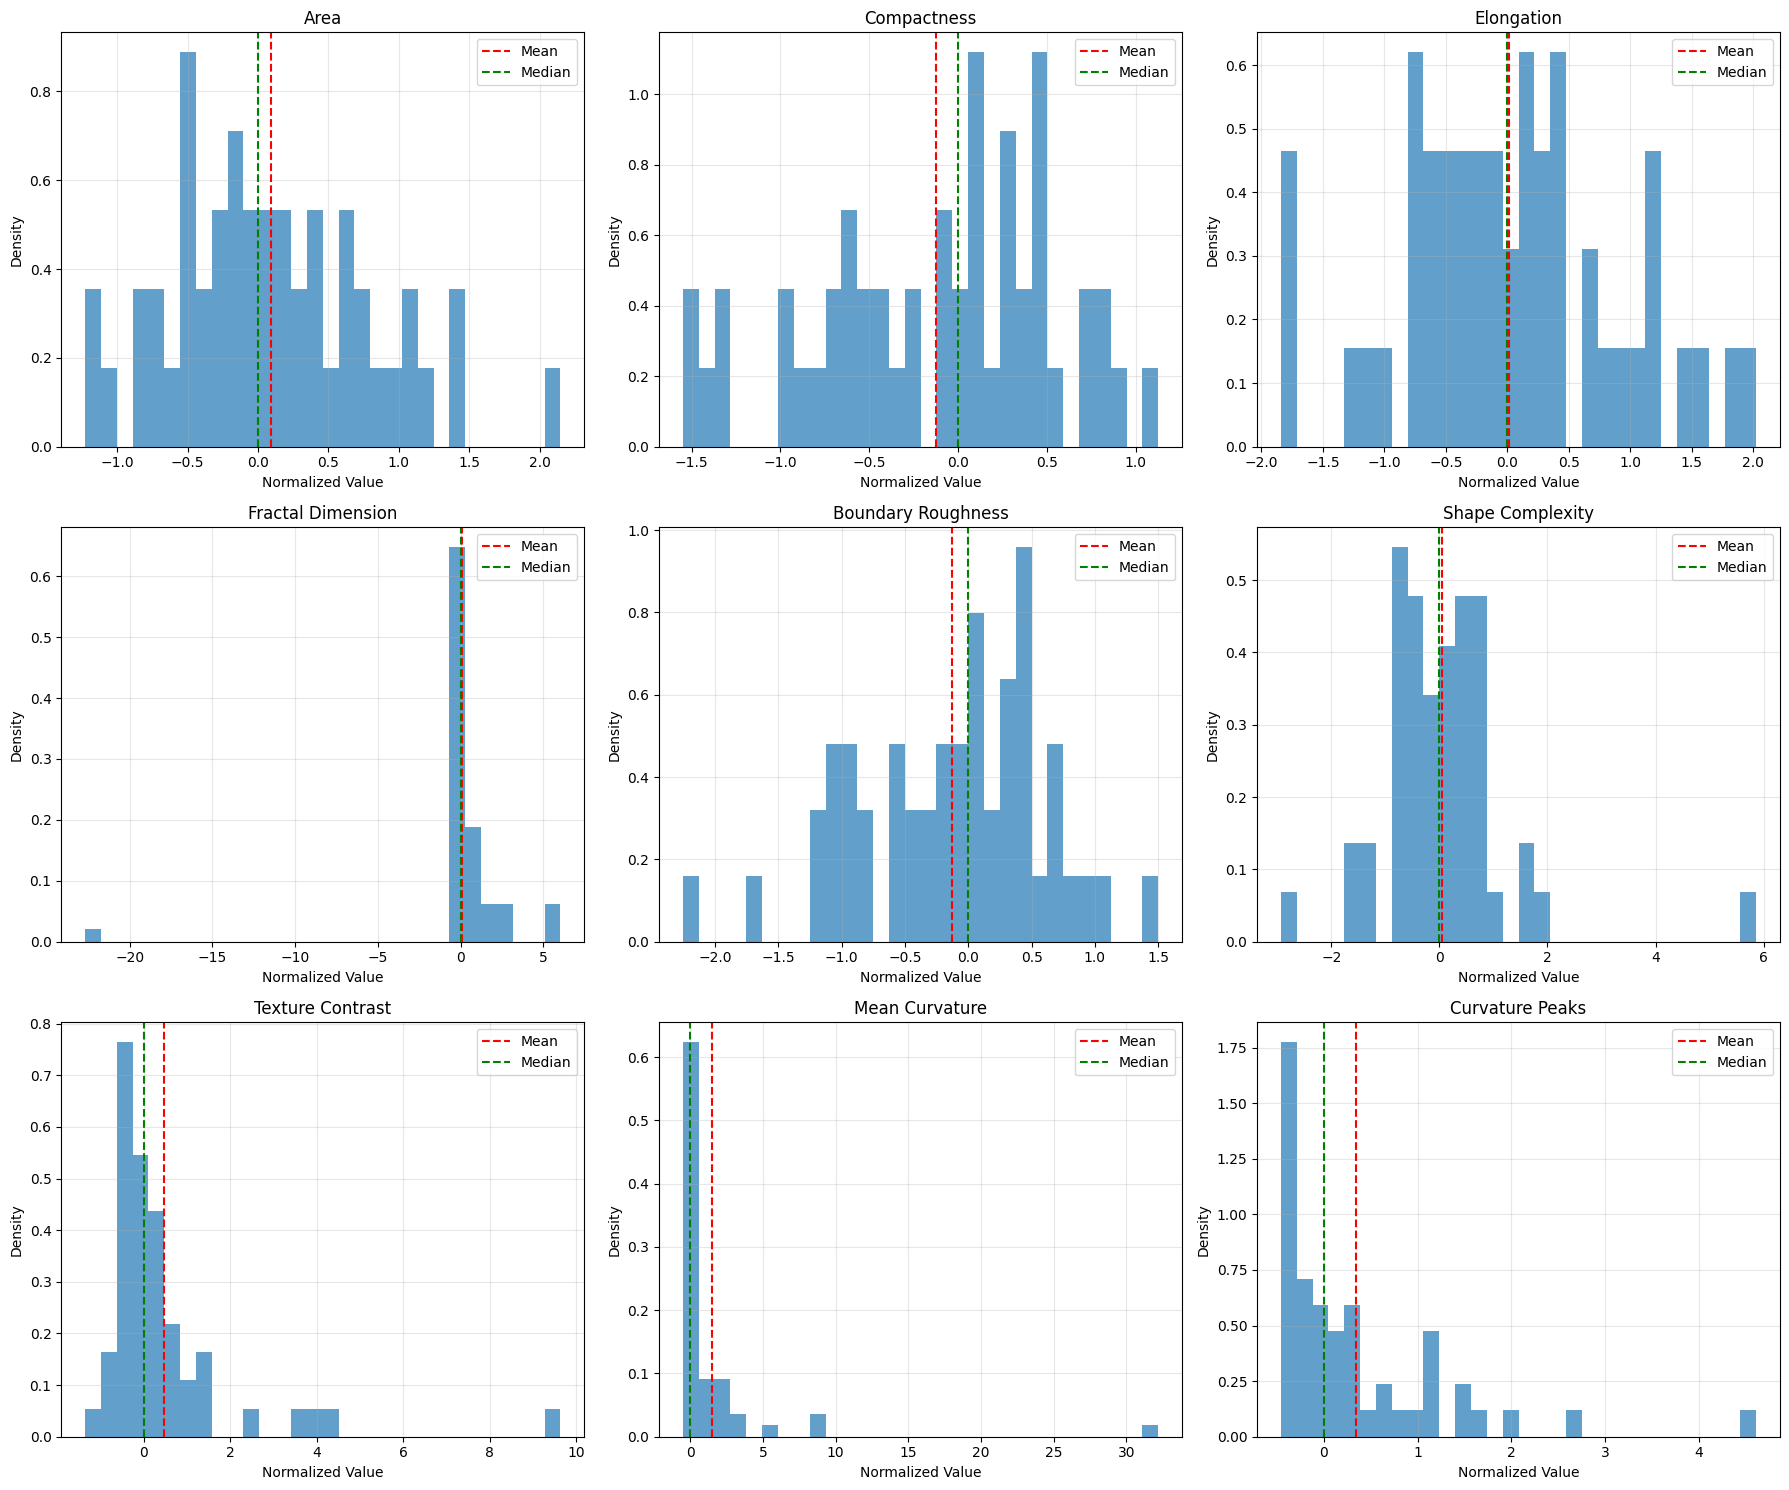

📊 Feature Statistics Summary
                          Mean     Std      Min     Max  Median
area                     0.091   0.723   -1.229   2.148     0.0
perimeter                0.320   1.479   -4.616   6.900     0.0
compactness             -0.125   0.678   -1.549   1.128     0.0
elongation               0.014   0.893   -1.842   2.026     0.0
solidity                -0.352   1.211   -4.797   0.684     0.0
extent                  -0.018   0.860   -2.382   1.938    -0.0
eccentricity             0.000   0.000    0.000   0.000     0.0
orientation             -0.065   0.890   -2.069   1.558     0.0
fractal_dimension        0.103   3.650  -22.692   6.023    -0.0
boundary_roughness      -0.130   0.742   -2.254   1.501     0.0
convexity_defects        0.204   1.015   -1.234   5.234     0.0
shape_complexity         0.055   1.214   -2.933   5.862     0.0
texture_contrast         0.468   1.751   -1.359   9.630     0.0
texture_homogeneity     -0.100   0.883   -3.930   1.498     0.0
texture_ene

In [7]:
def analyze_feature_distributions(features_df, normalized_df):
    """Analyze and visualize feature distributions"""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    # Select representative features from each category
    plot_features = [
        'area', 'compactness', 'elongation',  # Shape
        'fractal_dimension', 'boundary_roughness', 'shape_complexity',  # Complexity
        'texture_contrast', 'mean_curvature', 'curvature_peaks'  # Texture & Curvature
    ]

    for i, feature in enumerate(plot_features):
        row, col = divmod(i, 3)

        # Plot normalized features
        data = normalized_df[feature].dropna()
        if len(data) > 0:
            axes[row, col].hist(data, bins=30, alpha=0.7, density=True)
            axes[row, col].axvline(data.mean(), color='red', linestyle='--', label='Mean')
            axes[row, col].axvline(data.median(), color='green', linestyle='--', label='Median')
            axes[row, col].set_title(f'{feature.replace("_", " ").title()}')
            axes[row, col].set_xlabel('Normalized Value')
            axes[row, col].set_ylabel('Density')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature statistics summary
    print("📊 Feature Statistics Summary")
    print("=" * 40)
    stats_summary = normalized_df.describe().T[['mean', 'std', 'min', 'max', '50%']]
    stats_summary.columns = ['Mean', 'Std', 'Min', 'Max', 'Median']

    print(stats_summary.round(3))

# Analyze feature distributions
analyze_feature_distributions(features_df, normalized_features)


## 🔗 Feature Correlation Analysis
#
Understand how different features relate to each other and what they reveal about fire patterns.


🔗 Top Feature Correlations
area ↔ compactness: 0.842
area ↔ eccentricity: nan
area ↔ multi_scale_area: 1.000
perimeter ↔ eccentricity: nan
perimeter ↔ multi_scale_perimeter: 0.986
compactness ↔ eccentricity: nan
compactness ↔ multi_scale_area: 0.837
compactness ↔ solidity: 0.823
compactness ↔ extent: 0.769
area ↔ texture_energy: -0.755
area ↔ extent: 0.732
perimeter ↔ mean_curvature: 0.730
perimeter ↔ curvature_variance: 0.708
compactness ↔ texture_contrast: -0.659
perimeter ↔ curvature_peaks: 0.652


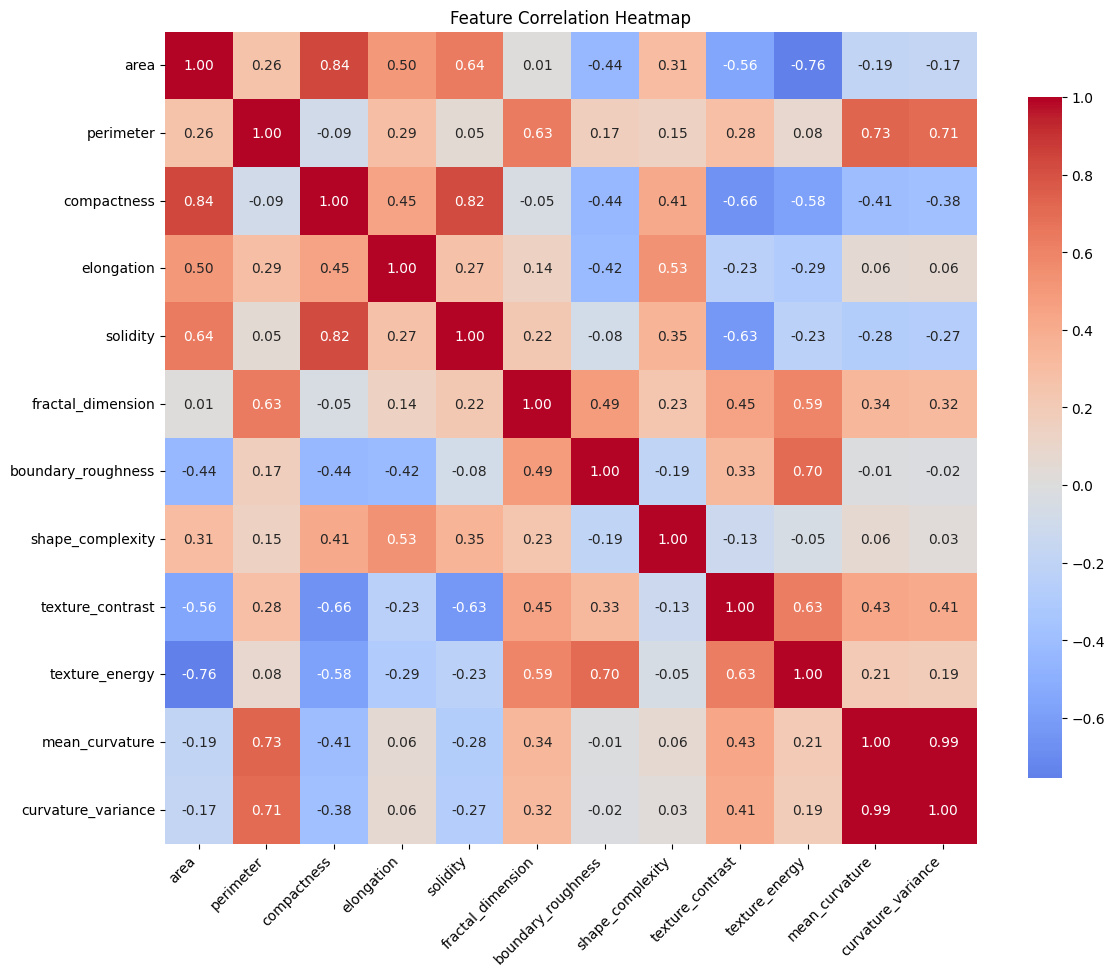

In [8]:
def analyze_feature_correlations(features_df, top_n=15):
    """Analyze correlations between features"""
    # Select numeric features
    numeric_features = features_df.select_dtypes(include=[np.number]).columns
    feature_data = features_df[numeric_features].fillna(0)

    # Calculate correlation matrix
    corr_matrix = feature_data.corr()

    # Find most correlated feature pairs
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

    # Sort by absolute correlation
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    print("🔗 Top Feature Correlations")
    print("=" * 40)
    for feat1, feat2, corr in corr_pairs[:top_n]:
        print(f"{feat1} ↔ {feat2}: {corr:.3f}")

    # Visualize correlation heatmap
    plt.figure(figsize=(12, 10))

    # Select subset of features for clearer visualization
    subset_features = [
        'area', 'perimeter', 'compactness', 'elongation', 'solidity',
        'fractal_dimension', 'boundary_roughness', 'shape_complexity',
        'texture_contrast', 'texture_energy', 'mean_curvature', 'curvature_variance'
    ]

    subset_corr = corr_matrix.loc[subset_features, subset_features]

    sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

    return corr_matrix

# Analyze feature correlations
correlation_matrix = analyze_feature_correlations(features_df)


## 🎯 Feature Importance Analysis
#
Determine which features are most important for classifying different fire characteristics.



🎯 Feature Importance for Fire Type
--------------------------------------------------
Classifier accuracy: 1.000
Top 10 features:
  1. shape_complexity: 0.0787
  2. multi_scale_complexity: 0.0766
  3. perimeter: 0.0652
  4. convexity_defects: 0.0640
  5. curvature_variance: 0.0595
  6. orientation: 0.0571
  7. extent: 0.0539
  8. mean_curvature: 0.0501
  9. boundary_roughness: 0.0496
  10. multi_scale_perimeter: 0.0492

🎯 Feature Importance for Size Category
--------------------------------------------------
Classifier accuracy: 1.000
Top 10 features:
  1. curvature_peaks: 0.0724
  2. compactness: 0.0619
  3. perimeter: 0.0618
  4. multi_scale_perimeter: 0.0557
  5. mean_curvature: 0.0551
  6. shape_complexity: 0.0528
  7. area: 0.0526
  8. orientation: 0.0498
  9. multi_scale_area: 0.0488
  10. texture_correlation: 0.0480
Classifier accuracy: 1.000
Top 10 features:
  1. shape_complexity: 0.0787
  2. multi_scale_complexity: 0.0766
  3. perimeter: 0.0652
  4. convexity_defects: 0.0640


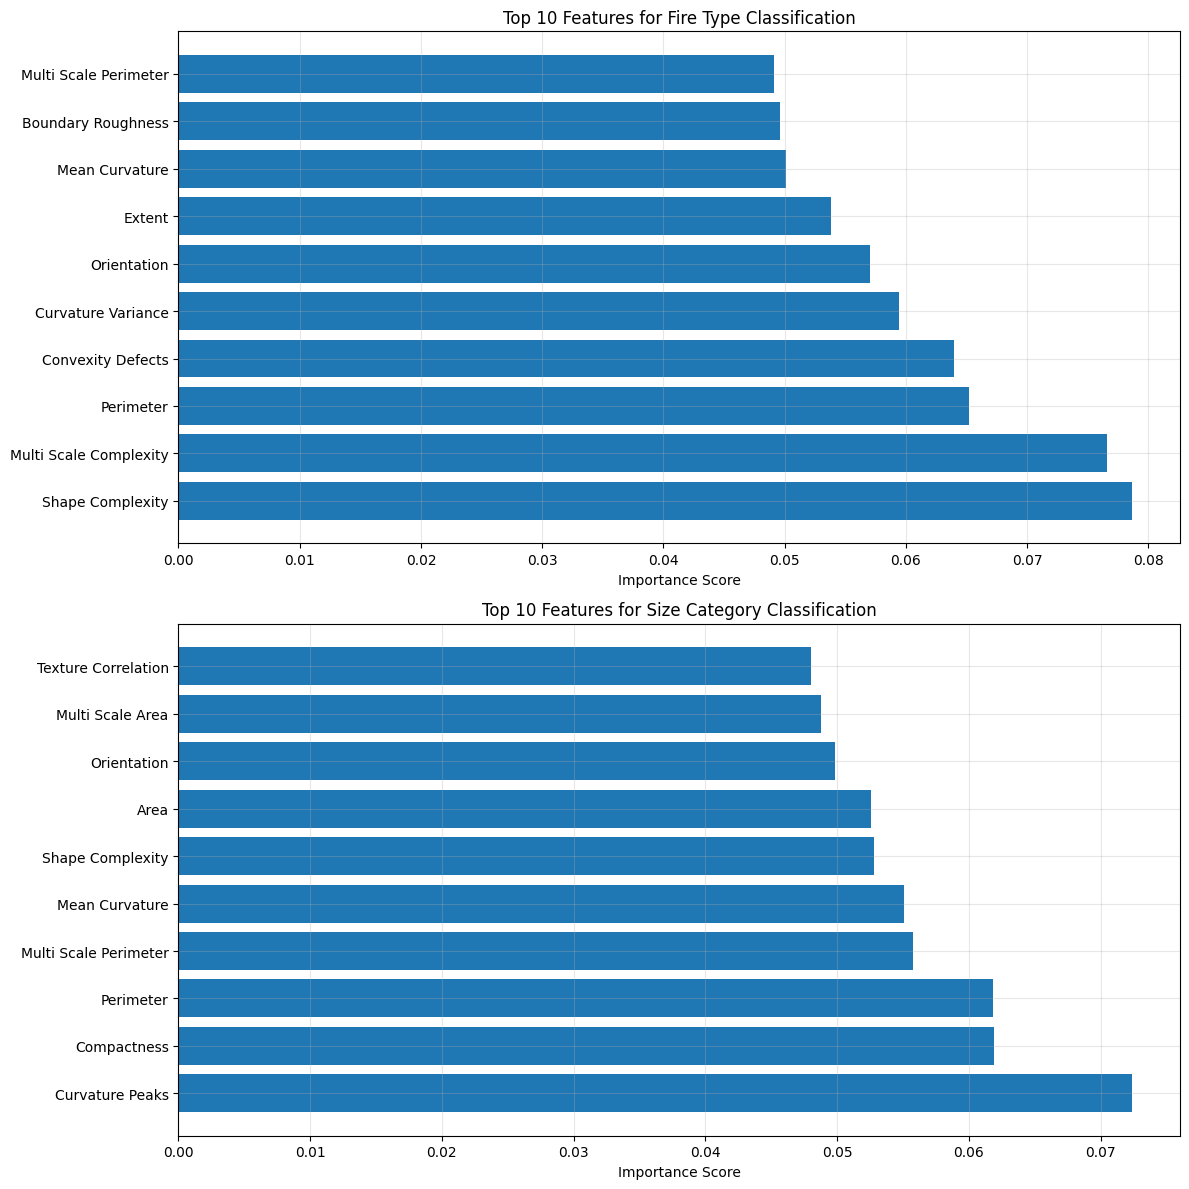

In [9]:
def analyze_feature_importance(features_df, labels, tasks=['fire_type', 'size_category']):
    """Analyze feature importance for different classification tasks"""
    fig, axes = plt.subplots(len(tasks), 1, figsize=(12, 6*len(tasks)))

    if len(tasks) == 1:
        axes = [axes]

    for i, task in enumerate(tasks):
        print(f"\n🎯 Feature Importance for {task.replace('_', ' ').title()}")
        print("-" * 50)

        # Get feature importance
        importance_results = analyzer.get_feature_importance(features_df, labels, task)

        print(f"Classifier accuracy: {importance_results['classifier_score']:.3f}")

        # Plot top 10 features
        top_n = 10
        feature_names = importance_results['feature_names'][:top_n]
        importances = importance_results['importances'][:top_n]

        axes[i].barh(range(len(feature_names)), importances)
        axes[i].set_yticks(range(len(feature_names)))
        axes[i].set_yticklabels([name.replace('_', ' ').title() for name in feature_names])
        axes[i].set_xlabel('Importance Score')
        axes[i].set_title(f'Top {top_n} Features for {task.replace("_", " ").title()} Classification')
        axes[i].grid(True, alpha=0.3)

        # Print top features
        print("Top 10 features:")
        for j, (name, imp) in enumerate(zip(feature_names, importances)):
            print(f"  {j+1}. {name}: {imp:.4f}")

    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze feature importance
analyze_feature_importance(normalized_features, labels)


## 🔬 Feature-Fingerprint Relationship Visualization
#
Show how features relate to the visual appearance of fingerprints.


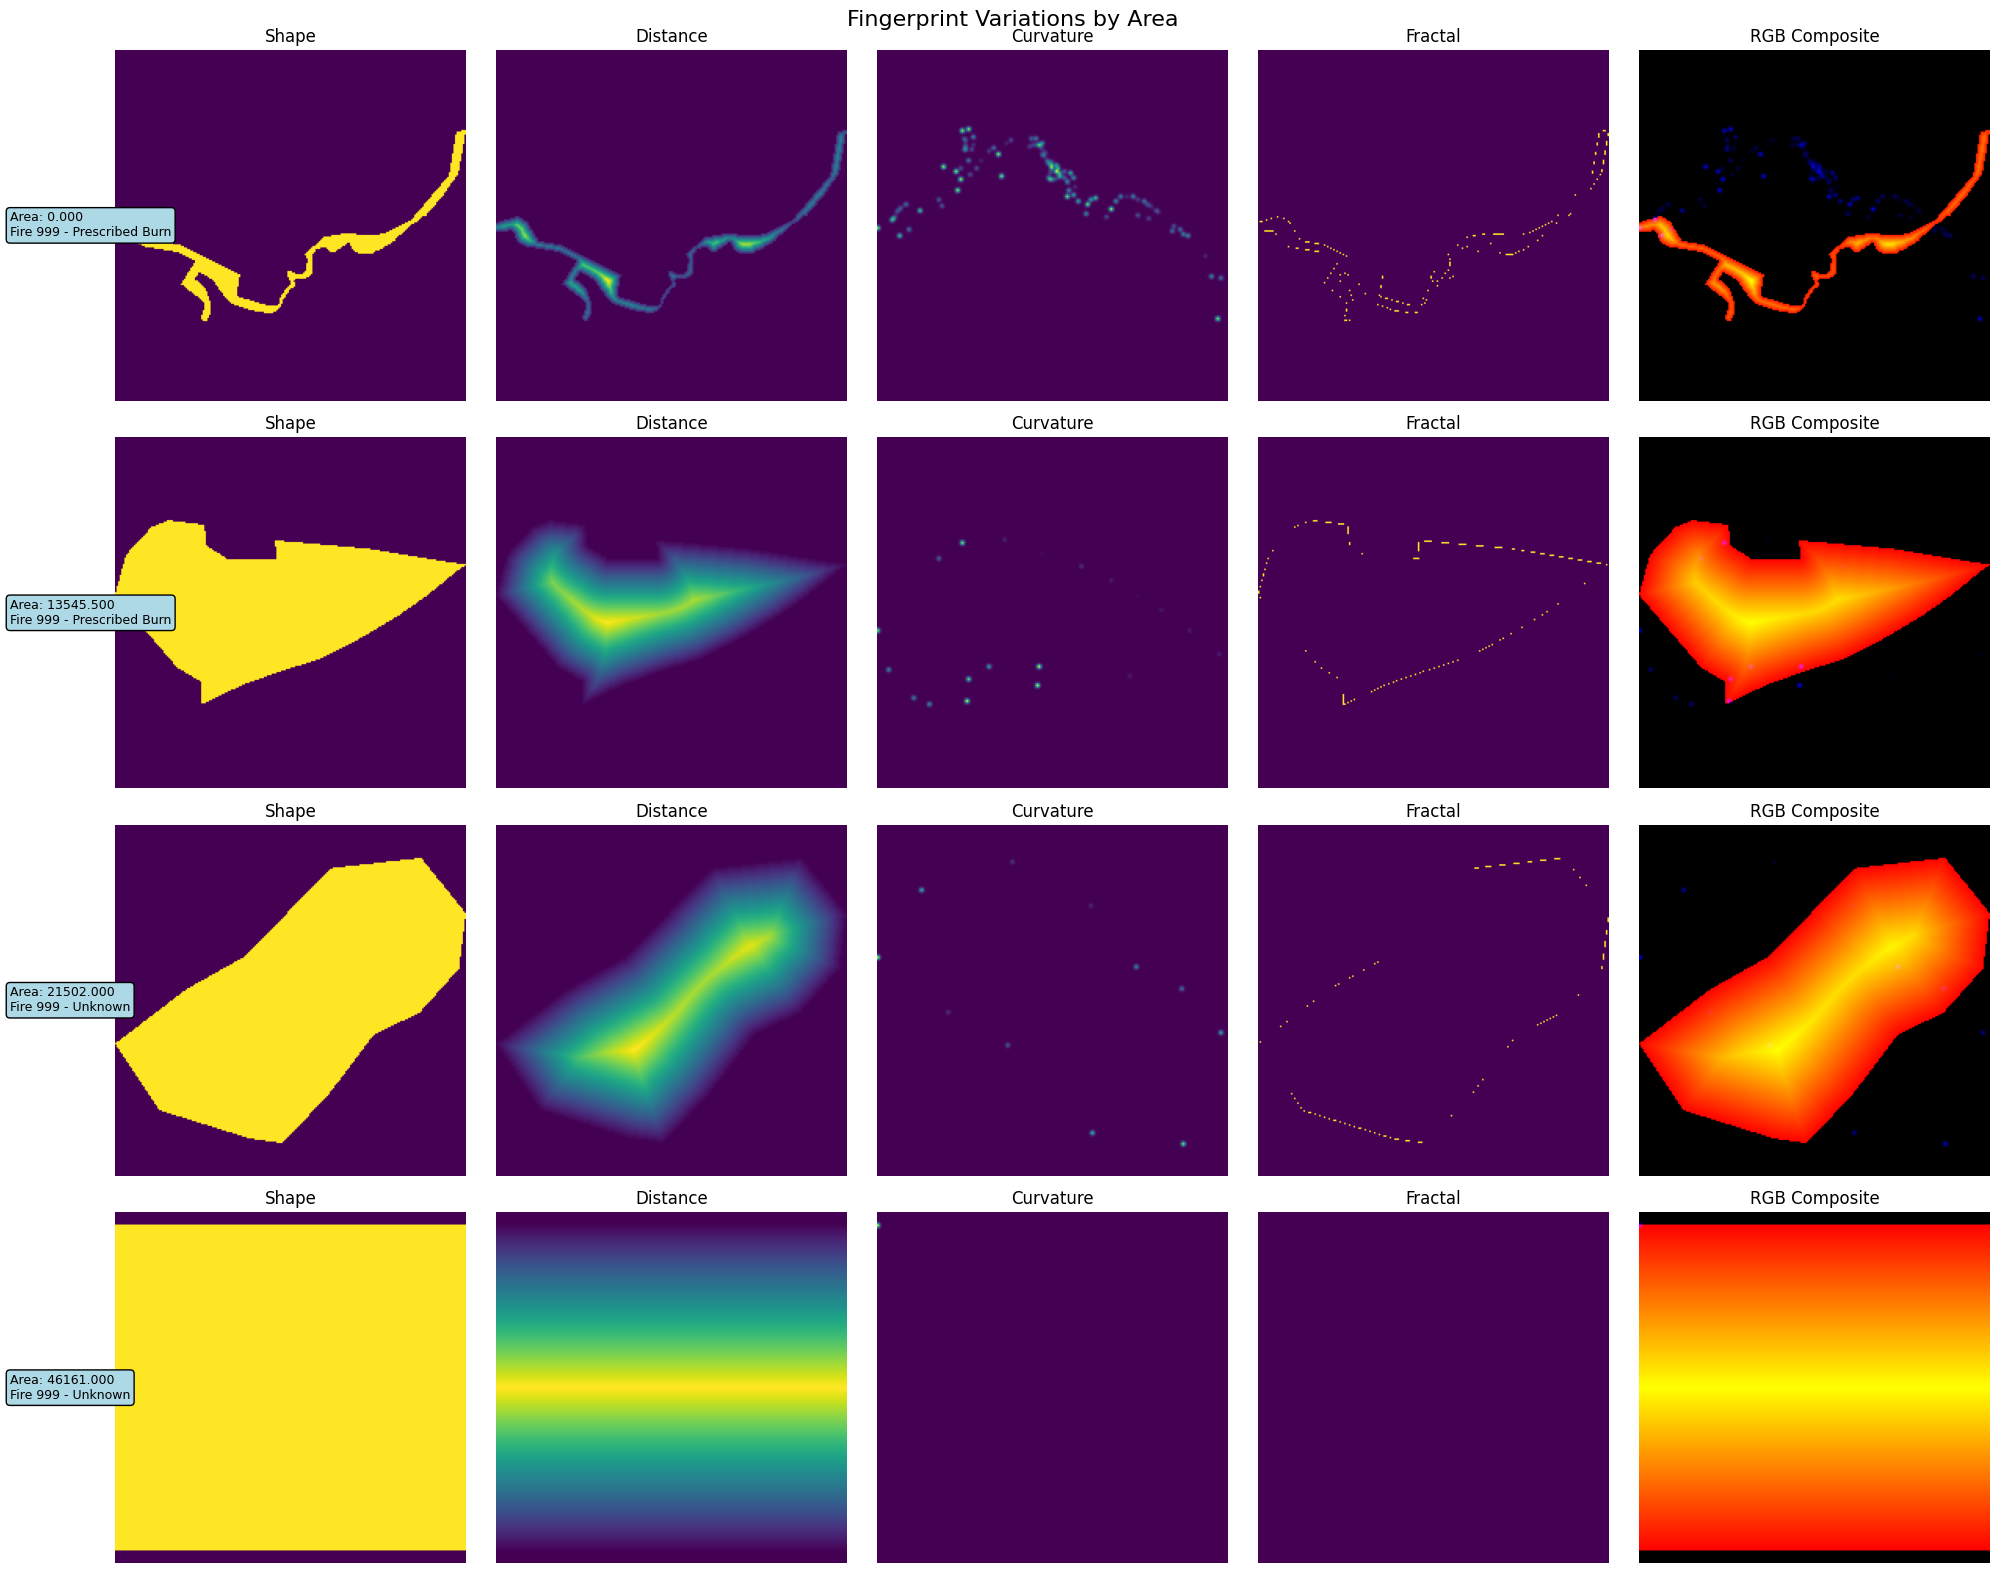

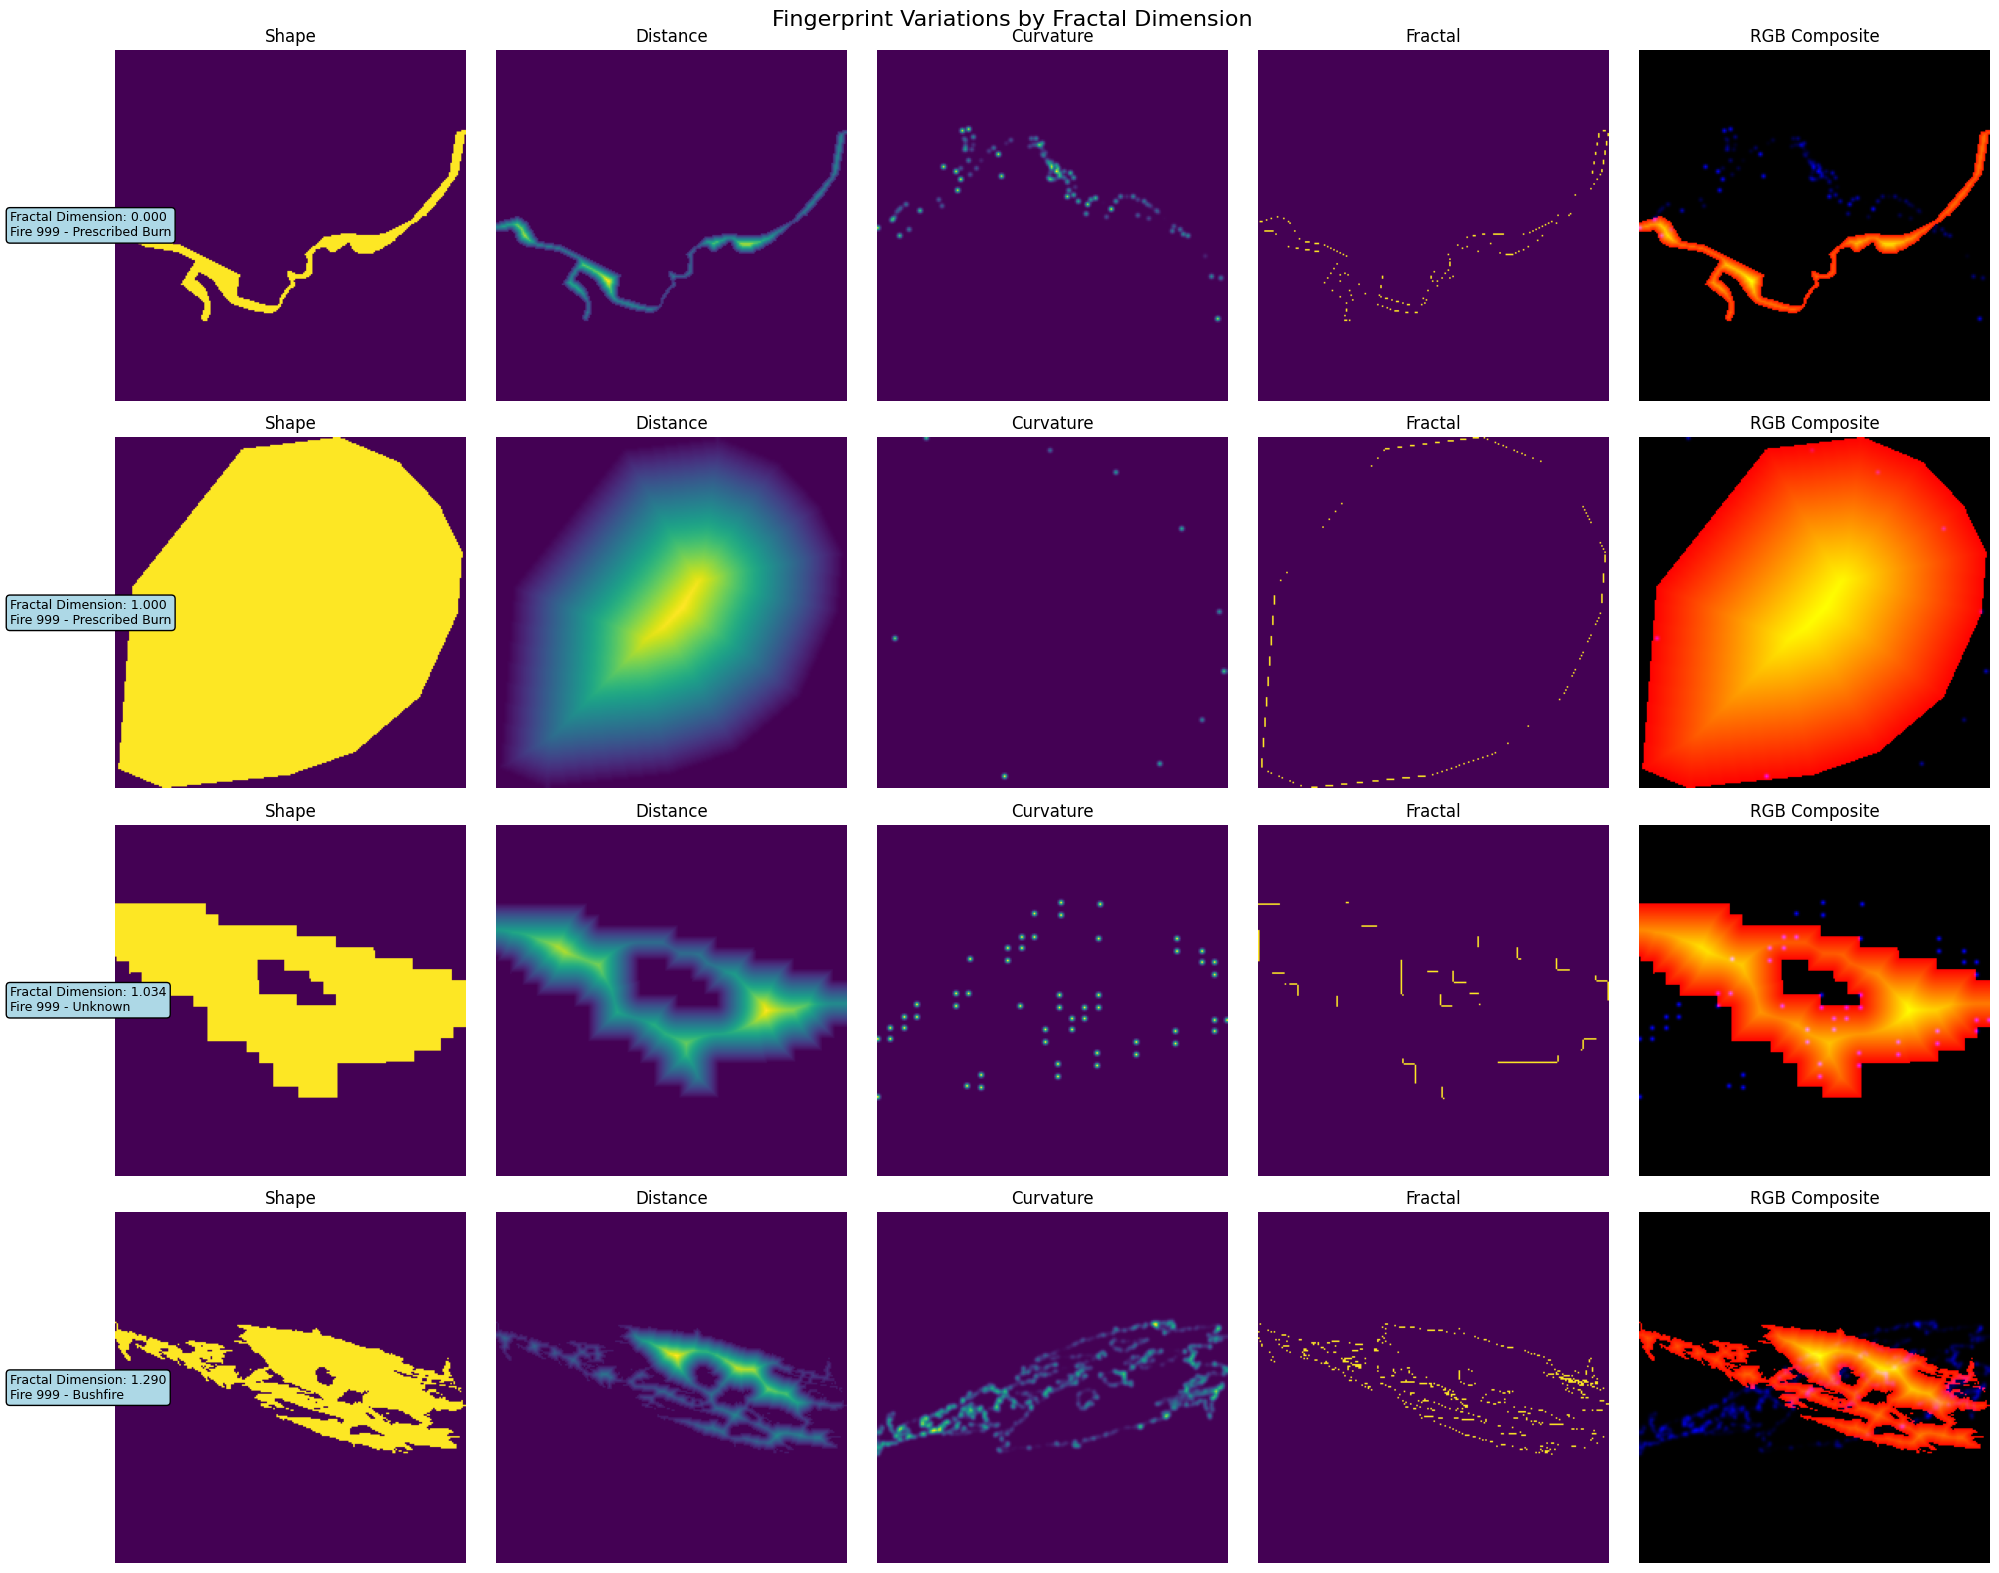

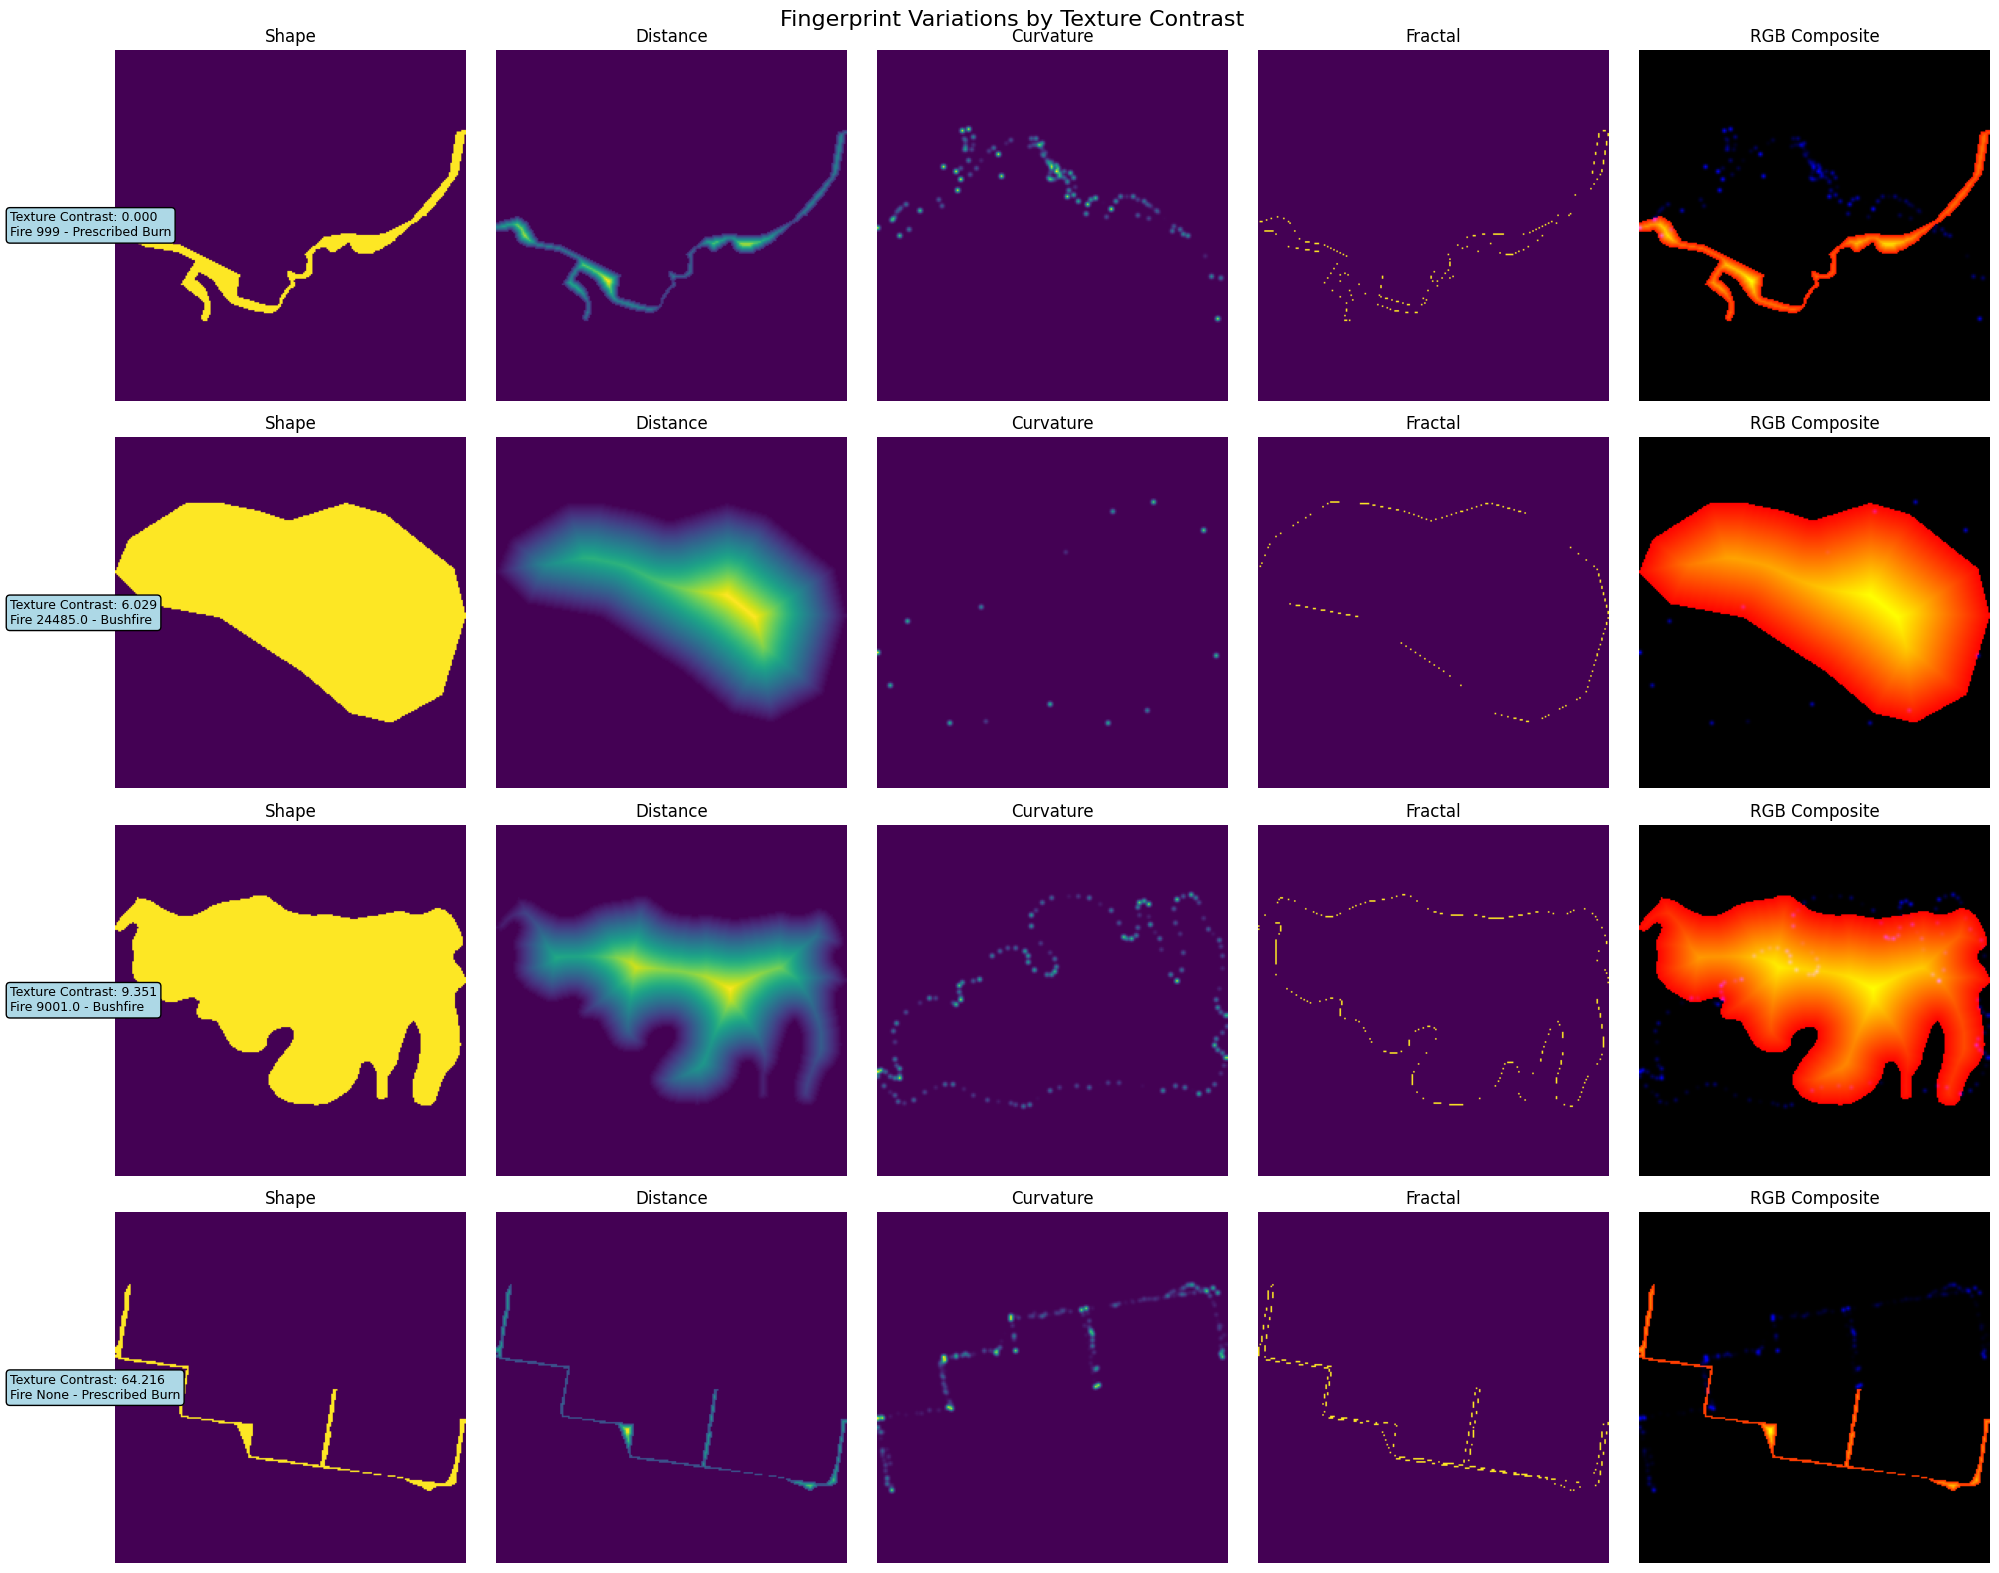

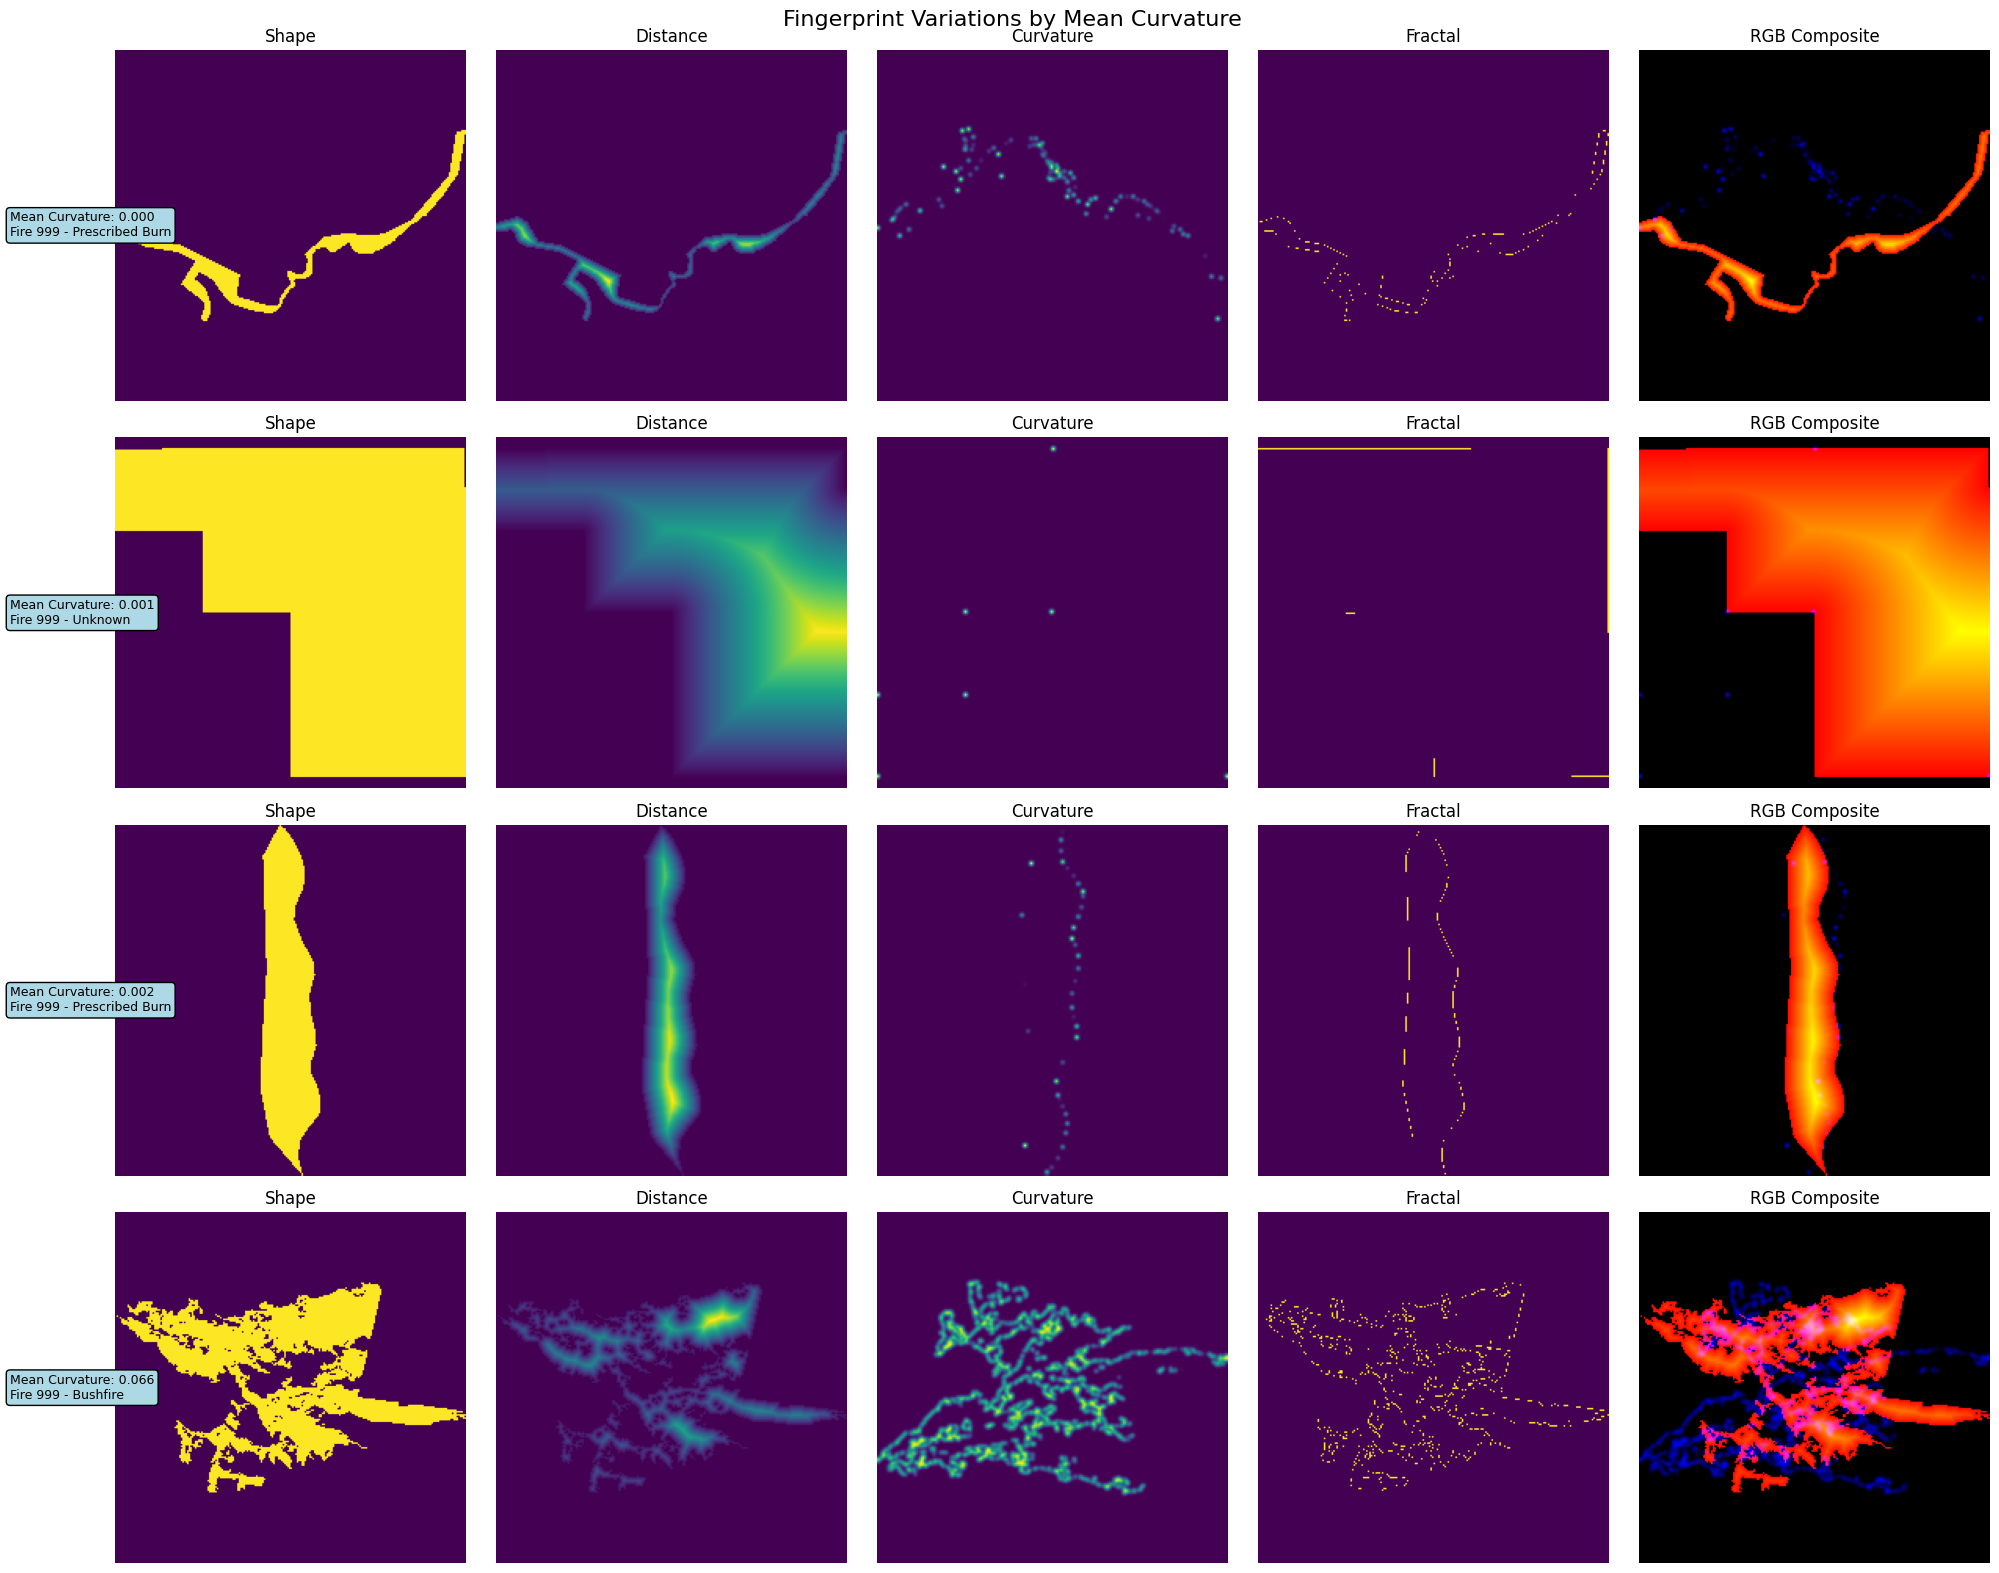

In [10]:
def visualize_feature_fingerprint_relationship(fingerprints, features_df, feature_name, n_samples=6):
    """Visualize relationship between features and fingerprint appearance"""
    # Get feature values
    feature_values = features_df[feature_name].values

    # Select samples with diverse feature values
    sorted_indices = np.argsort(feature_values)
    sample_indices = np.linspace(0, len(sorted_indices)-1, n_samples, dtype=int)
    selected_indices = sorted_indices[sample_indices]

    fig, axes = plt.subplots(n_samples, 5, figsize=(20, 4*n_samples))

    channel_names = ['Shape', 'Distance', 'Curvature', 'Fractal', 'RGB Composite']

    for i, idx in enumerate(selected_indices):
        fingerprint = fingerprints[idx]
        feature_value = feature_values[idx]
        meta = metadata[idx]

        # Plot each channel
        for j in range(4):
            axes[i, j].imshow(fingerprint[:, :, j], cmap='viridis')
            axes[i, j].set_title(f'{channel_names[j]}')
            axes[i, j].axis('off')

        # RGB composite
        rgb_composite = fingerprint[:, :, :3]
        axes[i, 4].imshow(rgb_composite)
        axes[i, 4].set_title('RGB Composite')
        axes[i, 4].axis('off')

        # Add feature value and fire info
        feature_info = f"{feature_name.replace('_', ' ').title()}: {feature_value:.3f}\n"
        feature_info += f"Fire {meta['fire_id']} - {meta['original_fire_type']}"

        axes[i, 0].text(-0.3, 0.5, feature_info, transform=axes[i, 0].transAxes,
                       verticalalignment='center', fontsize=9,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.suptitle(f'Fingerprint Variations by {feature_name.replace("_", " ").title()}',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(f'feature_fingerprint_{feature_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize relationships for key features
key_features = ['area', 'fractal_dimension', 'texture_contrast', 'mean_curvature']
for feature in key_features:
    if feature in features_df.columns:
        visualize_feature_fingerprint_relationship(fingerprints, features_df, feature, n_samples=4)


## 💾 Feature Database Creation
#
Create a comprehensive feature database that can be used for similarity search and analysis.


In [11]:
def create_feature_database(features_df, normalized_features, metadata, labels, output_path="fire_feature_database"):
    """Create comprehensive feature database"""
    output_dir = Path(output_path)
    output_dir.mkdir(exist_ok=True)

    print(f"Creating feature database in {output_dir}...")

    # Save raw features
    features_df.to_csv(output_dir / 'raw_features.csv', index=False)

    # Save normalized features
    normalized_features.to_csv(output_dir / 'normalized_features.csv', index=False)

    # Save feature metadata
    feature_metadata = {
        'num_fires': len(features_df),
        'num_features': len(features_df.columns),
        'feature_names': features_df.columns.tolist(),
        'feature_descriptions': analyzer.feature_descriptions,
        'creation_date': str(pd.Timestamp.now()),
        'normalization_method': 'robust_statistics'
    }

    with open(output_dir / 'feature_metadata.json', 'w') as f:
        json.dump(feature_metadata, f, indent=2, default=str)

    # Save fire metadata and labels
    fire_info = []
    for i, meta in enumerate(metadata):
        fire_data = meta.copy()
        fire_data.update(labels[i])
        fire_info.append(fire_data)

    fire_df = pd.DataFrame(fire_info)
    fire_df.to_csv(output_dir / 'fire_metadata.csv', index=False)

    # Create feature statistics summary
    stats = {
        'raw_stats': features_df.describe().to_dict(),
        'normalized_stats': normalized_features.describe().to_dict(),
        'feature_correlations': correlation_matrix.to_dict()
    }

    with open(output_dir / 'feature_statistics.json', 'w') as f:
        json.dump(stats, f, indent=2, default=str)

    print("✓ Feature database created with files:")
    print(f"  - raw_features.csv: {len(features_df)} fires × {len(features_df.columns)} features")
    print(f"  - normalized_features.csv: Normalized feature matrix")
    print(f"  - feature_metadata.json: Feature descriptions and metadata")
    print(f"  - fire_metadata.csv: Fire information and labels")
    print(f"  - feature_statistics.json: Statistical summaries")

    return str(output_dir)

# Create comprehensive feature database
database_path = create_feature_database(features_df, normalized_features, metadata, labels)


Creating feature database in fire_feature_database...
✓ Feature database created with files:
  - raw_features.csv: 50 fires × 23 features
  - normalized_features.csv: Normalized feature matrix
  - feature_metadata.json: Feature descriptions and metadata
  - fire_metadata.csv: Fire information and labels
  - feature_statistics.json: Statistical summaries


## 🎯 Key Insights and Applications
#
### What We've Accomplished:
#
1. **Comprehensive Feature Extraction**: 20+ geometric and textural features
2. **Multi-Scale Analysis**: Features computed at different scales
3. **Advanced Pattern Recognition**: Fractal dimensions, curvature, texture analysis
4. **Statistical Analysis**: Distributions, correlations, and importance analysis
5. **Feature Database**: Structured database for similarity search applications
#
### Feature Categories and Insights:
#
#### Shape Features:
- **Area & Perimeter**: Basic fire size measurements
- **Compactness**: How "circular" the fire is (higher = more contained)
- **Elongation**: Fire spread pattern (higher = more elongated)
- **Solidity**: Boundary complexity (lower = more irregular)
#
#### Complexity Features:
- **Fractal Dimension**: Self-similarity and natural complexity (1.0-2.0 range)
- **Boundary Roughness**: Edge irregularity and burning patterns
- **Convexity Defects**: Number of "bays" or indentations in fire boundary
#
#### Texture Features:
- **Contrast**: Variation in distance transform (spread complexity)
- **Homogeneity**: Spatial uniformity of fire growth
- **Energy**: Overall texture strength
#
#### Curvature Features:
- **Mean/Max Curvature**: Boundary bending and complexity
- **Curvature Peaks**: Number of major boundary changes
#
### Applications:
#
1. **Fire Classification**: Features enable accurate fire type prediction
2. **Similarity Search**: Find fires with similar burning patterns
3. **Risk Assessment**: Complex fires may indicate challenging terrain
4. **Pattern Discovery**: Clustering reveals common fire archetypes
5. **Research**: Quantitative analysis of fire behavior patterns


## 🚀 Summary
#
**Congratulations!** You've built a comprehensive fire pattern analysis system:
#
- ✅ **20+ geometric features** extracted from 4-channel fingerprints
- ✅ **Advanced complexity analysis** including fractal dimensions
- ✅ **Texture and curvature analysis** revealing burning patterns
- ✅ **Statistical insights** into feature distributions and correlations
- ✅ **Feature importance analysis** for classification tasks
- ✅ **Structured feature database** ready for similarity search
#
**Next notebook**: We'll use these features to build a powerful similarity search
engine that can find fires with similar patterns and characteristics.

print("\n" + "="*60)
print("🎉 PATTERN ANALYSIS & FEATURE EXTRACTION COMPLETE!")
print("="*60)
print("Ready for the next phase: Similarity Search & Clustering")
